In [25]:
import certifi
import os
os.environ['SSL_CERT_FILE'] = certifi.where()

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision import models

# Settings
nz = 100  # Size of noise vector
batch_size = 128
num_epochs = 25
lr = 0.0002

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Prepare transformers
transform = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download the CelebA dataset
dataset = dsets.CelebA(root='./data', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [47]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [48]:
resnet = models.resnet18(pretrained=True)

# # Freeze the weights of the pre-trained model

for param in resnet.parameters():
    param.requires_grad = False

# Feature extraction from ResNet
class FeatureExtractor(nn.Module):
    def __init__(self, resnet):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x):
        return self.features(x)

feature_extractor = FeatureExtractor(resnet).to(device)

In [49]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [50]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
img_list = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator: max log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator: min log(1 - D(G(z))) <-> max log(D(G(z)))
        netG.zero_grad()
        label.fill_(1.)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1} / {D_G_z2}')

    # Save generated images each epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

[0/25][0/1272] Loss_D: 1.430762767791748 Loss_G: 6.8163628578186035 D(x): 0.508053183555603 D(G(z)): 0.5158129930496216 / 0.0012435357784852386
[0/25][50/1272] Loss_D: 0.15609648823738098 Loss_G: 4.222186088562012 D(x): 0.9474234580993652 D(G(z)): 0.06209104508161545 / 0.03195493295788765
[0/25][100/1272] Loss_D: 1.7109501361846924 Loss_G: 0.9220923781394958 D(x): 0.3924805521965027 D(G(z)): 0.19964559376239777 / 0.48698368668556213
[0/25][150/1272] Loss_D: 1.2722983360290527 Loss_G: 1.6417585611343384 D(x): 0.35632264614105225 D(G(z)): 0.047618620097637177 / 0.2265872061252594
[0/25][200/1272] Loss_D: 0.7932181358337402 Loss_G: 2.7112374305725098 D(x): 0.8390316367149353 D(G(z)): 0.4285516142845154 / 0.0741499662399292
[0/25][250/1272] Loss_D: 2.098389148712158 Loss_G: 10.50771713256836 D(x): 0.9643313884735107 D(G(z)): 0.8557989597320557 / 0.0002011586184380576
[0/25][300/1272] Loss_D: 0.8575507402420044 Loss_G: 1.733055830001831 D(x): 0.7642831802368164 D(G(z)): 0.39633846282958984 

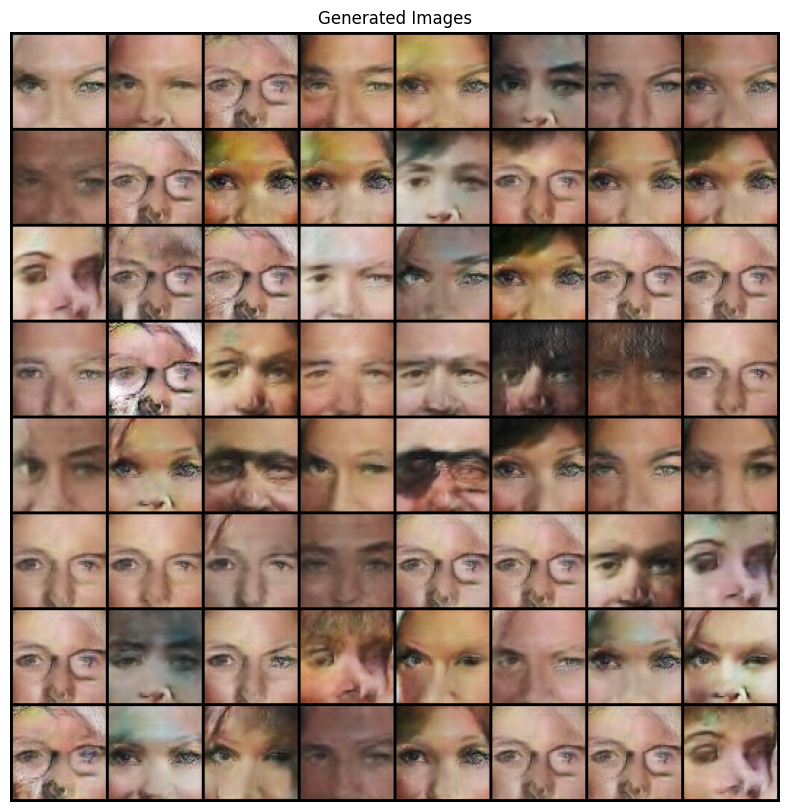

In [ ]:
# Displaying generated images
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()

In [57]:
# Save trained models
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')

In [58]:
# Creating model instance
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

# Load saved weights
netG.load_state_dict(torch.load('generator.pth'))
netD.load_state_dict(torch.load('discriminator.pth'))

# Make sure that models are in the evaluation mode
netG.eval()
netD.eval()


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [68]:
def generate_image(generator, nz, device):
    # Create a random noise vector
    noise = torch.randn(1, nz, 1, 1, device=device)
    # Generate the image
    with torch.no_grad():
        generated_image = generator(noise).detach().cpu()
    # Normalize the image
    generated_image = (generated_image + 1) / 2  # Przeskalowanie do [0, 1]
    return generated_image


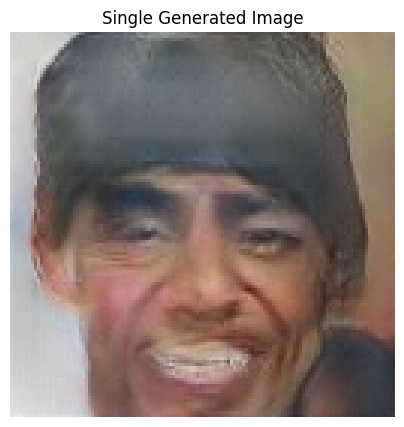

In [69]:

# Generating single image
generated_image = generate_image(netG, nz, device)

# Displaying generated image
plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Single Generated Image")
plt.imshow(np.transpose(generated_image[0], (1, 2, 0)))
plt.show()
